**Breast cancer** is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths.<br>
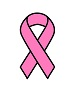
<br>This notebbok looks at the how a simple architecture such as **UNet** along with image augmentation techinique like **elastic deformation** can help in getting segmenataion result for cancerous cells and finally be used for classifying data into Normal and Cancerous.

**Unzip files for loading Data**<br>
For ease of acces Dataset is stored in zip

In [ ]:
# import zipfile
# with zipfile.ZipFile('breast ultrasound images.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

**Essential Imports**

In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers

**Data loading** <br>
Whenever an image has more than 1 mask we perform a union on them to get a single mask per image

In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    #we will be using greyscale images for our dataset
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    '''
    By doing this, the pixel values are normalised and
    brought into a range that the neural network's activation functions and
    optimisation algorithms can deal with.
    '''
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [ ]:
size = 128   # image size: 128x128
X, y = load_data('breast ultrasound images/*/*', size)

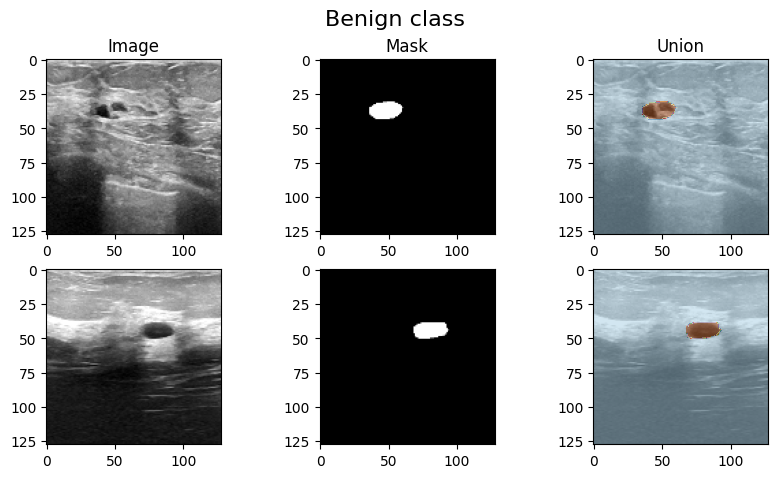

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(10,5))

i = np.random.randint(437)
j = np.random.randint(437)
ax[0][0].imshow(X[i], cmap='gray')
ax[0][0].set_title('Image')
ax[0][1].imshow(y[i], cmap='gray')
ax[0][1].set_title('Mask')
ax[0][2].imshow(X[i], cmap='gray')
ax[0][2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='Paired')
ax[0][2].set_title('Union')
ax[1][0].imshow(X[j], cmap='gray')
ax[1][1].imshow(y[j], cmap='gray')
ax[1][2].imshow(X[j], cmap='gray')
ax[1][2].imshow(tf.squeeze(y[j]), alpha=0.5, cmap='Paired')
fig.suptitle('Benign class', fontsize=16)
plt.show()

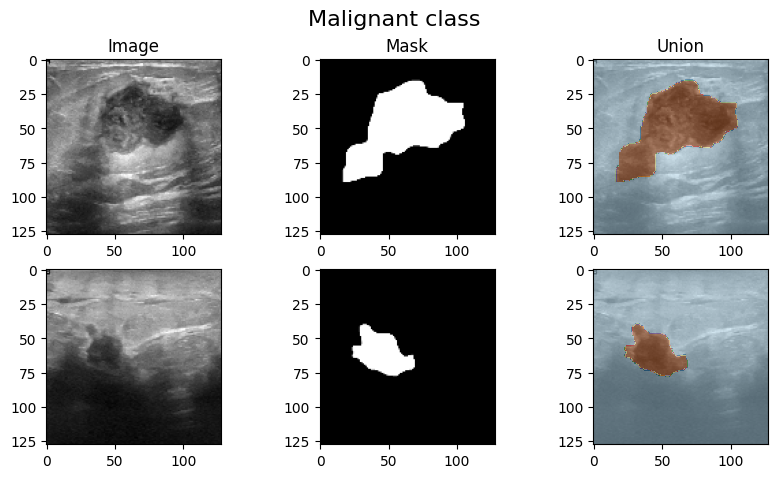

In [ ]:

fig, ax = plt.subplots(2,3, figsize=(10,5))
i = np.random.randint(437,647)
j = np.random.randint(437,647)
ax[0][0].imshow(X[i], cmap='gray')
ax[0][0].set_title('Image')
ax[0][1].imshow(y[i], cmap='gray')
ax[0][1].set_title('Mask')
ax[0][2].imshow(X[i], cmap='gray')
ax[0][2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='Paired')
ax[0][2].set_title('Union')
ax[1][0].imshow(X[j], cmap='gray')
ax[1][1].imshow(y[j], cmap='gray')
ax[1][2].imshow(X[j], cmap='gray')
ax[1][2].imshow(tf.squeeze(y[j]), alpha=0.5, cmap='Paired')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

**Data Preprocessing**

In [ ]:
#prepare data to modeling
#changes the shape from (n,w,h) -> (n,w,h,1), preferred dimension to pass to for model's first layer
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

In [ ]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((624, 128, 128, 1),
 (156, 128, 128, 1),
 (624, 128, 128, 1),
 (156, 128, 128, 1))

**Unet-architecture**
The image below represents a simplified version of the U-Net. As the network is composed of layer groups that are shaped like an U. The left part and foot of the U is called the contracting path, whereas the right part is called the expansive path. Jointly, and with the help of skip connections, U-nets downsample an input image to learn about its salient features, to reconstruct the input (or a derived product, like a segmentation mask) via upsampling.

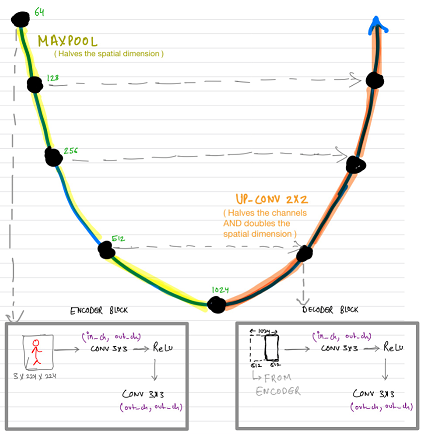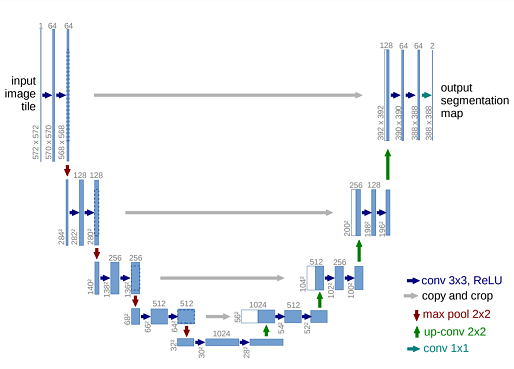

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

**Need for Skip Connections**:

*   During this downsampling process,finer details can be lost. By using skip connections, which connect the encoder and decoder at multiple scales, U-Net retains important high-resolution features from the encoder which are crucial for accurate segmentation.
*   Skip connections allow the decoder to access feature maps at different resolutions from the encoder.




In [ ]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam",metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])

In [ ]:
#to print a useful summary of the model
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_76[0][0]']              
                                )                                                             

In [ ]:
#train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((499, 128, 128, 1),
 (156, 128, 128, 1),
 (499, 128, 128, 1),
 (156, 128, 128, 1))

The Unet paper mentions Elastic transformation to be very critical whenever there is shortage of training data<br>
**"*Especially random elastic deformations of the training samples seem to be the key concept to train
a segmentation network with very few annotated images*"**

In [ ]:
def elastic_transform(image, mask, alpha_affine):

    random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    mask = cv2.warpAffine(mask, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    return image, mask

el_tf_train_images_1 = [elastic_transform(img, mask, img.shape[1] * 0.04) for img,mask in zip(X_train,y_train )]
el_tf_train_images_2 = [elastic_transform(img, mask, img.shape[1] * 0.08) for img,mask in zip(X_train,y_train )]
el_tf_train_images_3 = [elastic_transform(img, mask, img.shape[1] * 0.12) for img,mask in zip(X_train,y_train )]
el_tf_train_images_4 = [elastic_transform(img, mask, img.shape[1] * 0.16) for img,mask in zip(X_train,y_train )]

el_tf_train_images_list = [el_tf_train_images_1, el_tf_train_images_2, el_tf_train_images_3, el_tf_train_images_4]
# el_tf_train_images_list = [el_tf_train_images_1]


for each_el_tf in el_tf_train_images_list:
    el_tf_imgs,  el_tf_masks = zip(*each_el_tf)
    el_tf_imgs = list(el_tf_imgs)
    el_tf_masks = list(el_tf_masks)
    X_train = np.concatenate((X_train, np.expand_dims(el_tf_imgs, -1)))
    y_train = np.concatenate((y_train, np.expand_dims(el_tf_masks, -1)))


X_train.shape

(2495, 128, 128, 1)

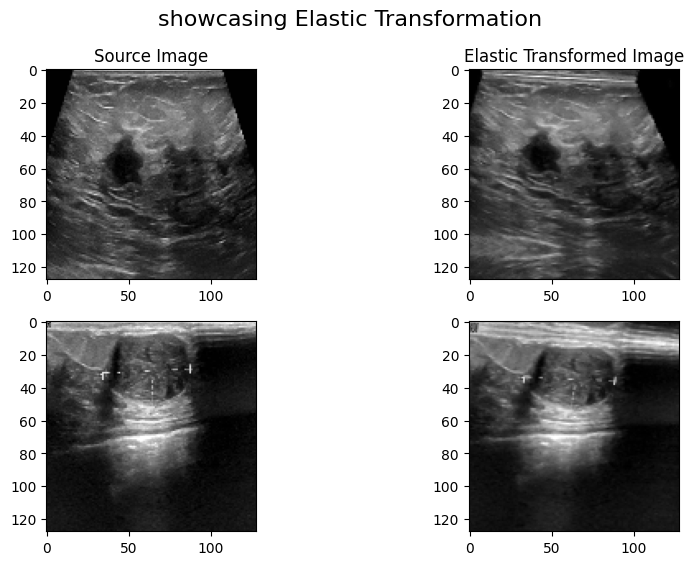

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

ax[0][0].imshow(X_train[2], cmap='gray')
ax[0][0].set_title('Source Image')
ax[0][1].imshow(X_train[2+499*3], cmap='gray')
ax[0][1].set_title('Elastic Transformed Image')
ax[1][0].imshow(X_train[4], cmap='gray')
ax[1][1].imshow(X_train[4+499*3], cmap='gray')
fig.suptitle('showcasing Elastic Transformation', fontsize=16)
plt.show()

We will also try using data/image augmentation as part of the data pipeline, using vertical/horizontal flips and rotations as mentioned in the paper.

In [ ]:
batch_size = 1
def augment(image, mask):
  do_flip_h = tf.random.uniform([]) > 0.5
  image = tf.cond(do_flip_h, lambda: tf.image.flip_left_right(image), lambda: image)
  mask = tf.cond(do_flip_h, lambda: tf.image.flip_left_right(mask), lambda: mask)

  do_flip_v = tf.random.uniform([]) > 0.5
  image = tf.cond(do_flip_h, lambda: tf.image.random_flip_up_down(image), lambda: image)
  mask = tf.cond(do_flip_h, lambda: tf.image.random_flip_up_down(mask), lambda: mask)


  do_rotate = tf.random.uniform([]) > 0.5
  rot_steps = tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)
  image = tf.cond(do_flip_h, lambda: tf.image.rot90(image, k=rot_steps), lambda: image)
  mask = tf.cond(do_flip_h, lambda: tf.image.rot90(mask, k=rot_steps), lambda: mask)


  return image, mask

In [ ]:
#using patience as 5 for early stopping
callback = tf.keras.callbacks.EarlyStopping(patience=5)

ds_x = tf.data.Dataset.from_tensor_slices(X_train)
ds_y = tf.data.Dataset.from_tensor_slices(y_train)
train_ds = tf.data.Dataset.zip((ds_x, ds_y))
'''
Commenting the flip and rotation as it's not improving model accuracy
'''
# train_ds = (
#     train_ds
#     .shuffle(1000)
#     .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(tf.data.AUTOTUNE)
# )
history = model.fit(X_train, y_train , epochs = 50,validation_data = (X_val,y_val), callbacks=[callback], verbose=1)

Epoch 1/50
78/78 [==============================] - 36s 361ms/step - loss: 0.3520 - accuracy: 0.8949 - IoU: 0.4595 - val_loss: 0.2247 - val_accuracy: 0.9448 - val_IoU: 0.4733
Epoch 2/50
78/78 [==============================] - 28s 359ms/step - loss: 0.2628 - accuracy: 0.9099 - IoU: 0.4595 - val_loss: 0.1565 - val_accuracy: 0.9482 - val_IoU: 0.4733
Epoch 3/50
78/78 [==============================] - 28s 353ms/step - loss: 0.2131 - accuracy: 0.9173 - IoU: 0.4595 - val_loss: 0.1368 - val_accuracy: 0.9530 - val_IoU: 0.4733
Epoch 4/50
78/78 [==============================] - 27s 351ms/step - loss: 0.1852 - accuracy: 0.9288 - IoU: 0.4595 - val_loss: 0.1355 - val_accuracy: 0.9536 - val_IoU: 0.4733
Epoch 5/50
78/78 [==============================] - 28s 355ms/step - loss: 0.1689 - accuracy: 0.9348 - IoU: 0.4595 - val_loss: 0.1261 - val_accuracy: 0.9568 - val_IoU: 0.4733
Epoch 6/50
78/78 [==============================] - 27s 352ms/step - loss: 0.1509 - accuracy: 0.9423 - IoU: 0.4595 - val_loss

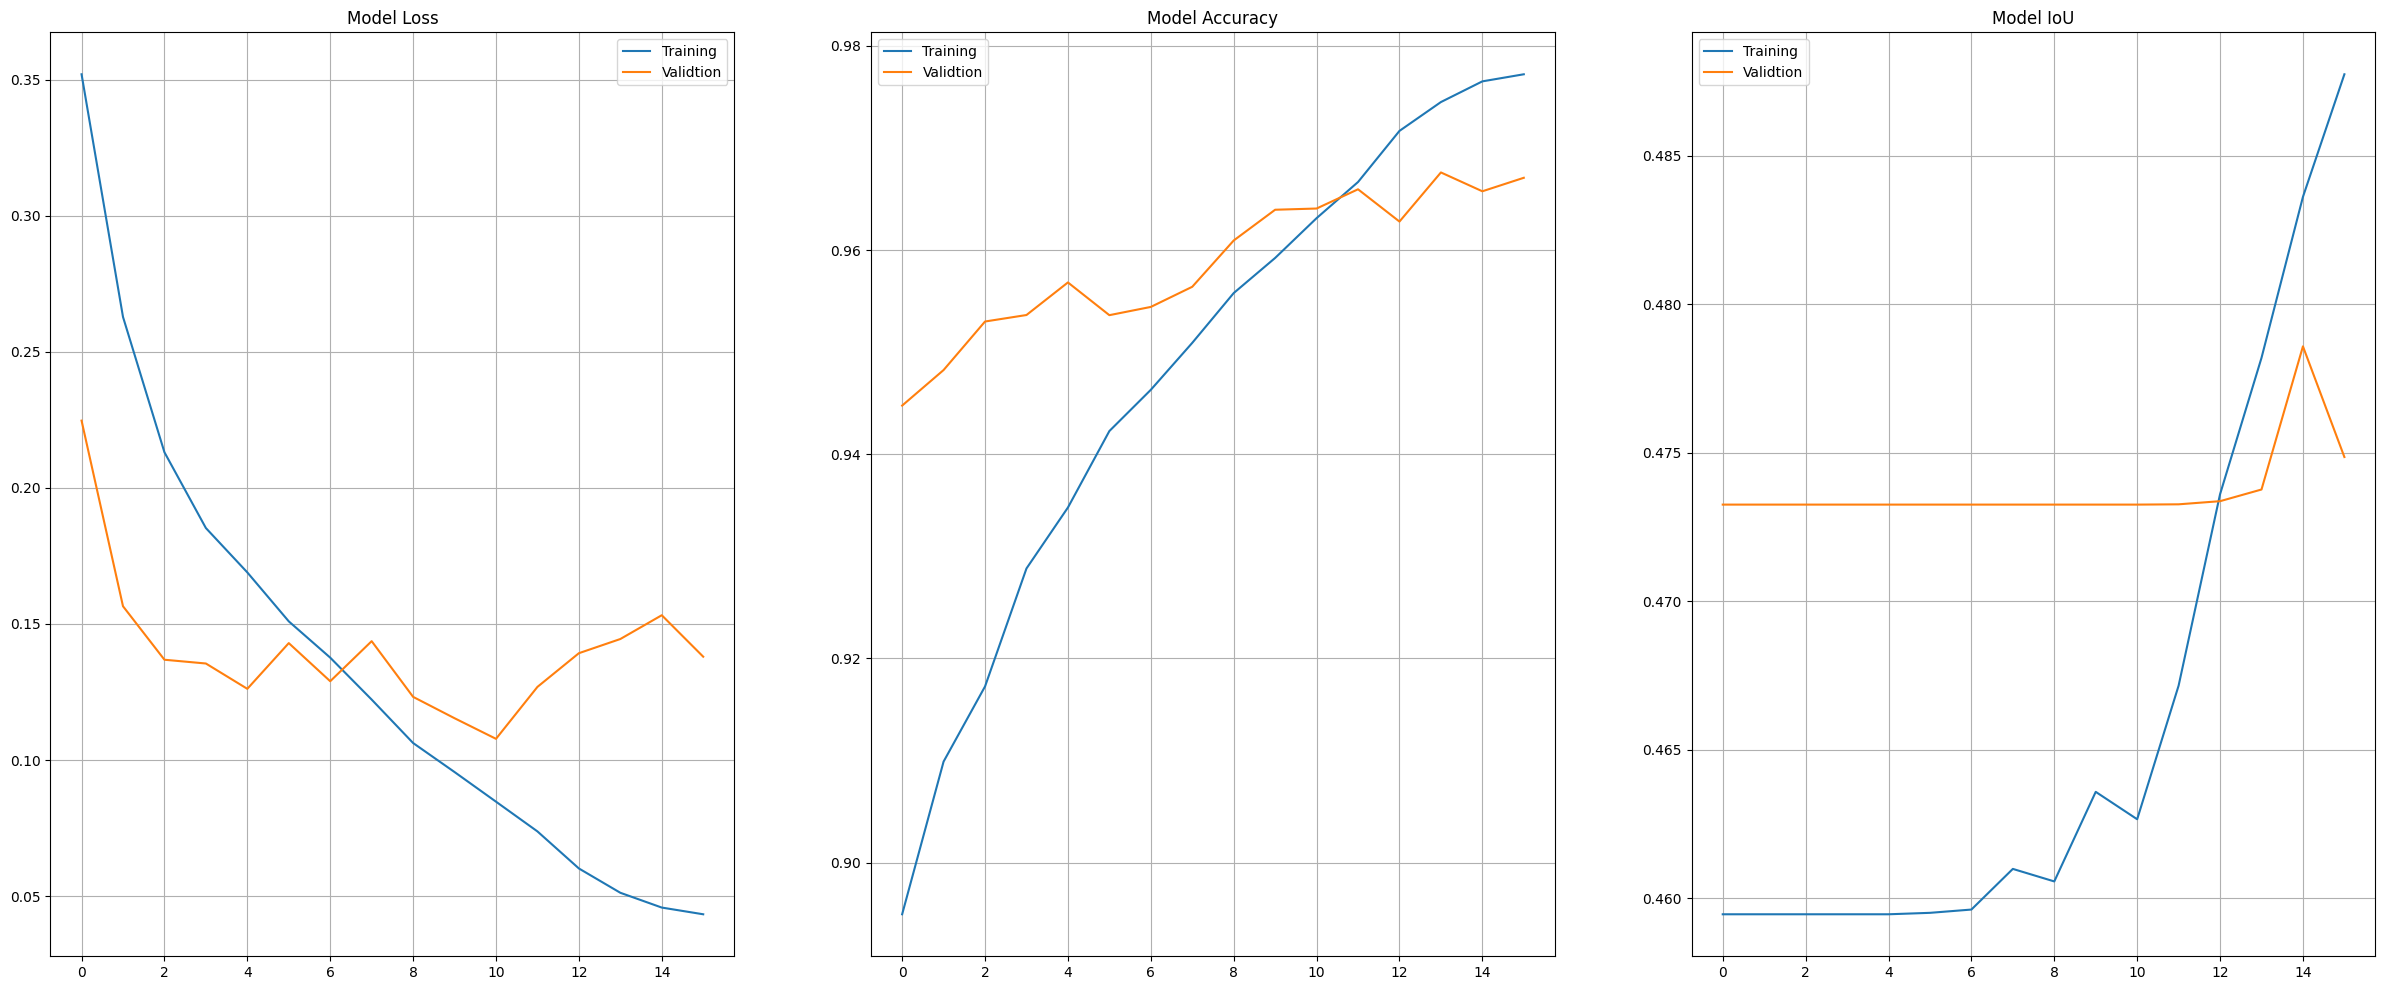

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = history.history.values()
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

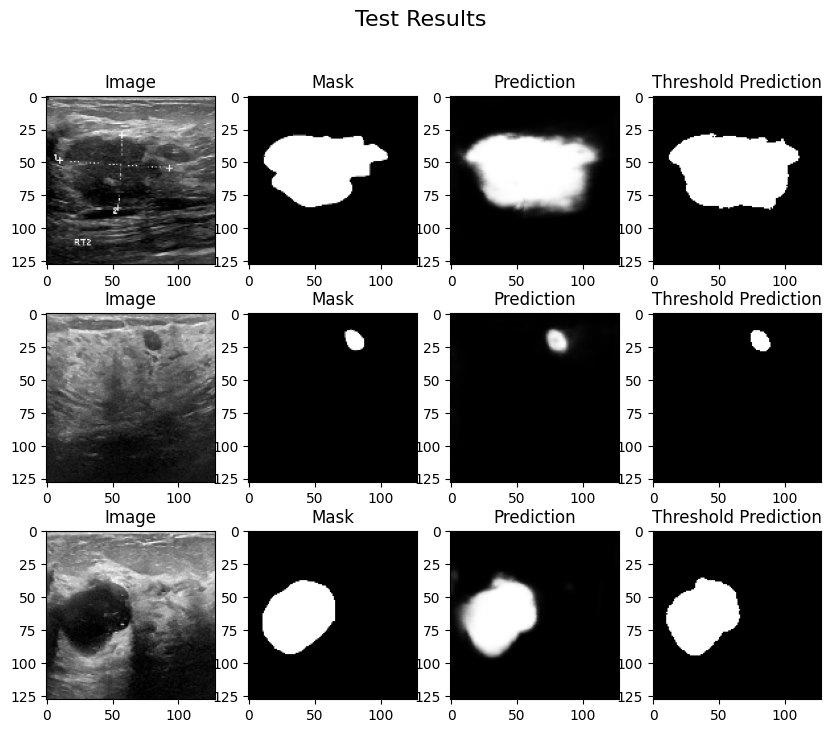

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(10,8))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(3):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
    ax[i,3].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0]>0.5, cmap='gray')
    ax[i,3].set_title('Threshold Prediction')
fig.suptitle('Test Results', fontsize=16)
plt.show()

# *   Evaluating the model on test dataset.
# *   Here the metrics are with reference to image segmentation problem




In [ ]:
y_pred=model.predict(X_test,verbose=0)

#The threshold value 0.5 can be experimented with
y_pred_thresholded = y_pred > 0.50

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

acc_score = Accuracy()
acc_score.update_state(y_pred_thresholded, y_test)
acc = acc_score.result().numpy()
print('Accuracy Score = %.3f' % acc)

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.79044247
Accuracy Score = 0.965
Precision Score = 0.695
Recall Score = 0.844
F1 Score = 0.762


# Visualizing the results as per classification approach<br>
we map the mask to labels and compare with the converted model prediction<br>




In [ ]:
y_gt = []
y_pd = []
for true_mask, pred_mask in zip(y_test, y_pred_thresholded):
  # print(np.count_nonzero(true_mask))
  # print(np.count_nonzero(pred_mask))
  if np.count_nonzero(true_mask):
    label = True
  else:
    label = False
  if np.count_nonzero(pred_mask):
    pred = True
  else:
    pred = False
  y_gt.append(label)
  y_pd.append(pred)

**We plot a confusion matrix for better visaulization**

<Figure size 1200x800 with 0 Axes>

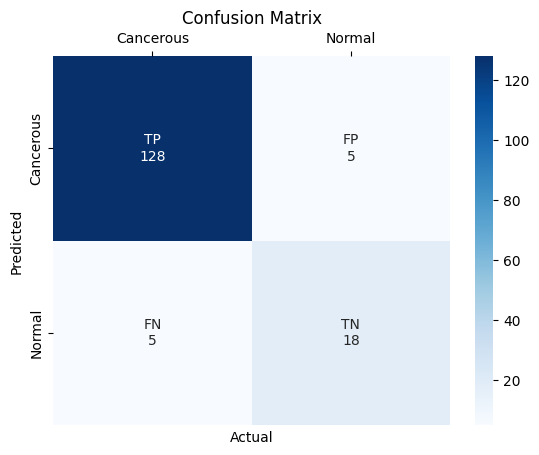

In [ ]:

cm = confusion_matrix(y_gt, y_pd)
classes = ["Normal", "Cancerous"]
plt.figure(figsize=(12, 8))
fig, ax = plt.subplots()
labels = ["TN" +'\n' +  str(cm[0][0]),"FN"+'\n' +  str(cm[0][1]),"FP"+'\n' +  str(cm[1][0]), "TP"+'\n' +  str(cm[1][1])]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
plt.yticks(np.arange(2)+.5, classes, rotation=90)
plt.xticks(np.arange(2)+.5, classes, rotation=0)
plt.xlabel("Actual")
ax.xaxis.set_ticks_position('top')
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

**Here the metrics are with reference to image classification problem**

In [ ]:

cm = confusion_matrix(y_gt, y_pd)
cm
TP = cm[1][1]
TN = cm[0][0]
FP = cm[1][0]
FN = cm[0][1]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = (TP)/(TP+FP)
recall = (TP)/(TP+FN)
f1_score = 2*(precision*recall)/(precision+recall)

print("TP FP FN TN")
print(TP, FP, FN, TN)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)

print('F1 Score', f1_score)


TP FP FN TN
128 5 5 18
accuracy 0.9358974358974359
precision 0.9624060150375939
recall 0.9624060150375939
F1 Score 0.9624060150375939


**We can see that we have decent accuracy and very good recall score, Which is suitable for our problem.**